# Notebook to explore the BOLDMoments data

**Data location:** /oliva/blahner/BOLDMoments/preprocessed_data/responses.

Reminder that reconstruction should be done per subject. Subject 1 is good. 
To get started, use: ./sub01/testing/X_TRavg-56789testing.pkl, where X is either the ROI name or WB (whole brain). The contents of the pkl file is a dict with keys "test_data" and "train_data" with shapes (num_videos, num_repetitions, num_voxels). Feel free to average over repetitions. You can also find the metadata json file and video stimuli in /oliva/datasets/BOLDMoments/metadata.


For time-resolved brain activity, use /sub01/testing/X_TRavg-Ytesting.pkl where Y is 5, 6, 7, 8, or 9. Don't worry about numbers 1-4. But I'd first start with the 56789avg to make sure we can get some reconstruction.


### FAQ
1. **Training vs testing folder?**

The data in the “testing” folder folder contains keys of “test_data” and “train_data”, so everything you need is in there. The reason why we have a dedicated “training” folder was for the challenge, where we didn’t want to release any test data. The “train_data” key in the “testing” folder is an exact copy of the data in the “training” folder.

2. **What are the different brain areas?**

PPA is scene-selective, LOC is object selective, OFA is face selective. PFop and PFt don’t have as nice a functional description, but are thought to be involved in a action mirroring network. More info to be added.

3. **What does time resolved mean?**

By time-resolved, we mean samples from different time points along the BOLD signal. There is not a straightforward mapping between time points along the BOLD signal and time points in the video. Different brain regions integrate information over time differently. So lots of open questions there, but in general we show that early (late) video frames correspond to early (late) samples along the BOLD signal

In [4]:
import sys
import os
import pickle as pkl
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [9]:
# Load pkl file with moments data

with open("./data/sub01/WB_TRavg-56789_testing.pkl", "rb") as f:
    data = pkl.load(f)

print(data)
print(data['test_data'].shape)

{'noise_ceiling': array([ 0.18175637,  0.23454077,  0.34508738, ...,  0.1399355 ,
        0.04457096, -0.06857824]), 'p_values': array([0.0990099 , 0.01980198, 0.00990099, ..., 0.22772277, 0.36633663,
       0.67326733]), 'nan_indices': array([0.00000e+00, 1.00000e+00, 2.00000e+00, ..., 5.15031e+05,
       5.15032e+05, 5.15033e+05]), 'train_data': array([[[ 1.00652658,  0.5014861 ,  0.88428398, ..., -0.36216733,
         -1.13355098, -0.5212484 ],
        [ 0.19570085,  0.94794238, -0.02165601, ..., -0.30541688,
          0.00941362,  0.13845932],
        [ 0.59445705,  0.44530229,  0.0467085 , ..., -0.95434785,
          0.09860132, -0.12931361]],

       [[-0.22539308,  0.01786901,  0.49588254, ...,  0.27360575,
          0.15266588, -0.34826202],
        [ 0.93116471,  1.12381873,  0.74230157, ...,  0.26379817,
          0.11740854,  0.70703196],
        [-0.83114302, -1.14896191,  0.76933264, ..., -0.33627207,
         -0.11313701,  0.3708633 ]],

       [[ 0.33401699,  0.46372998,

In [5]:
print(data.keys())

dict_keys(['test_data', 'train_data', 'noise_ceiling', 'p_values'])


In [6]:
# View (num_videos, num_repetitions, num_voxels) for each key
print(data['test_data'].shape)
print(data['train_data'].shape)
print(data['noise_ceiling'].shape)
print(data['p_values'].shape)


(102, 10, 237)
(1000, 3, 237)
(393,)
(393,)


(102, 237)


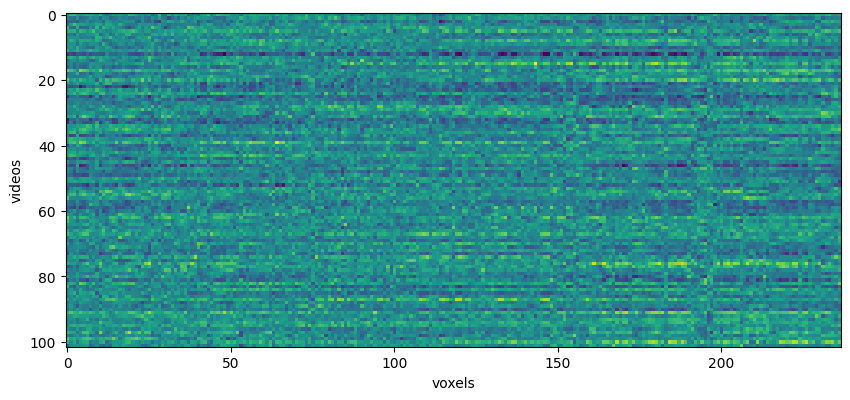

In [7]:
# Plot average value per voxel

def avg_value_per_voxel(data: dict, average_over: str='repetitions') -> None:
    """
    Plot average value per voxel, averaged across average_over (repetitions, frames or voxels)
    """

    if average_over == 'videos':
        dim = 0; ylabel='repetitions'; xlabel='voxels'
    elif average_over == 'repetitions':
        dim = 1; ylabel='videos'; xlabel='voxels'
    elif average_over == 'voxels':
        dim = 2; ylabel='videos'; xlabel='repetitions'
    else:
        raise ValueError('average_over must be one of "videos", "repetitions" or "voxels"')

    avg_per_voxel = np.mean(data['test_data'], axis=dim)
    print(avg_per_voxel.shape)
    plt.figure(figsize=(10, 12))
    plt.imshow(avg_per_voxel, cmap='viridis')
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.show()


avg_value_per_voxel(data, average_over='repetitions')


In [8]:
def load_all_fmri_for_subject(path_to_subject_data: str) -> dict:
    """
    Load all fmri data for a subject into a dict with brain locations as keys
    """

    fmri_data = {}

    for p in os.listdir(path_to_subject_data):
        if '56789' not in p: continue
        
        brain_region = p.split('_')[0]

        with open(os.path.join(path_to_subject_data, p), 'rb') as f:
            data = pkl.load(f)
            fmri_data[brain_region] = data

    return fmri_data

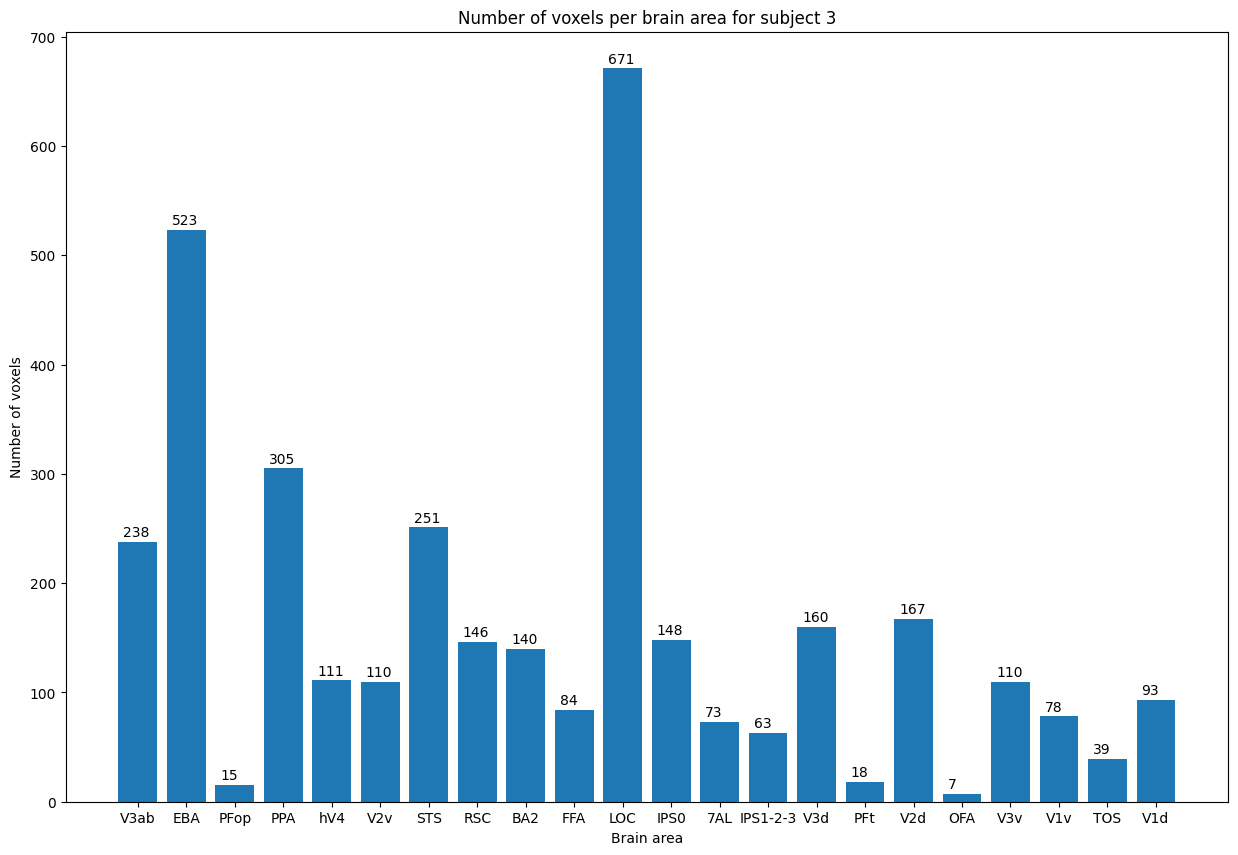

In [9]:
# Bar chart with number of voxels for each brain area

def num_voxels_per_brain_area(path: str) -> None:

    fmri_data = load_all_fmri_for_subject(path)

    voxels = {}
    for brain_area, data in fmri_data.items():
        if brain_area == 'WB': continue
        voxels[brain_area] = data['test_data'].shape[2]

    plt.figure(figsize=(15, 10))
    plt.bar(voxels.keys(), voxels.values())
    plt.xlabel('Brain area')
    plt.ylabel('Number of voxels')
    plt.title('Number of voxels per brain area for subject 3')
    # Show numbers on top of bars
    for i, v in enumerate(voxels.values()):
        plt.text(i - 0.3, v + 5, str(v))
    plt.show()

num_voxels_per_brain_area("./data/sub03")
        

['sub01', 'sub02', 'sub03', 'sub04', 'sub05', 'sub06', 'sub07', 'sub08', 'sub09', 'sub10']
{'V3ab': [237, 279, 238, 257, 144, 204, 127, 205, 276, 184], 'EBA': [441, 337, 523, 483, 405, 371, 145, 179, 410, 280], 'PFop': [122, 65, 15, 53, 46, 58, 41, 73, 87, 92], 'PPA': [366, 153, 305, 231, 210, 212, 155, 269, 159], 'hV4': [108, 95, 111, 118, 77, 106, 84, 95, 59], 'V2v': [77, 81, 110, 47, 77, 121, 64, 84, 57, 91], 'STS': [249, 430, 251, 359, 217, 184, 91, 293, 342, 126], 'RSC': [216, 247, 146, 220, 127, 209, 94, 185, 55], 'BA2': [319, 231, 140, 103, 116, 249, 60, 193, 268, 215], 'FFA': [69, 157, 84, 250, 70, 128, 94, 200, 75, 69], 'LOC': [736, 683, 671, 698, 546, 635, 636, 608, 560], 'IPS0': [156, 170, 148, 188, 146, 146, 133, 203, 125], '7AL': [81, 80, 73, 86, 75, 123, 23, 81, 75, 38], 'IPS1-2-3': [115, 113, 63, 116, 105, 106, 88, 141, 80], 'V3d': [156, 157, 160, 138, 89, 133, 130, 161, 123], 'PFt': [107, 81, 18, 42, 48, 83, 34, 67, 68, 53], 'V2d': [147, 150, 167, 164, 117, 157, 152, 21

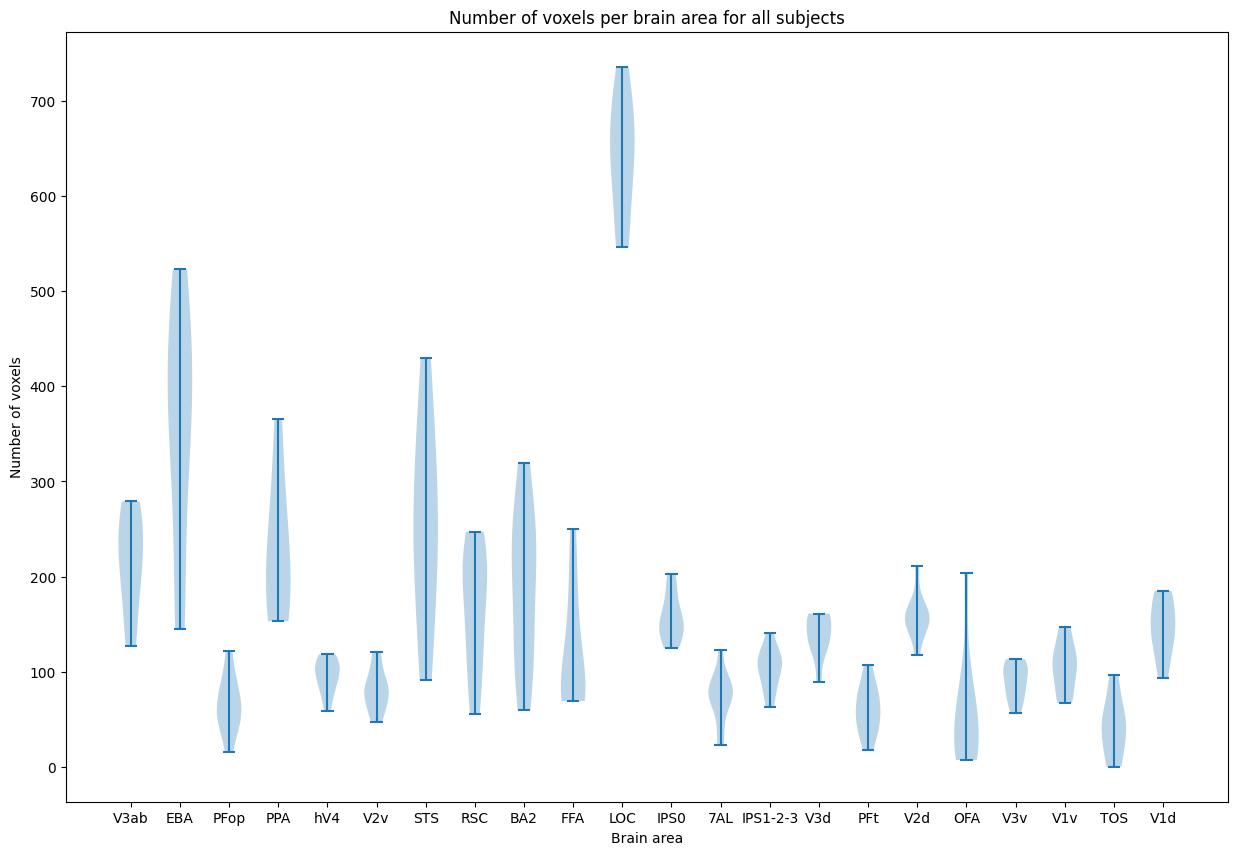

In [10]:
# Violin plot of number of voxels per brain area over all subjects

def num_voxels_per_brain_area_all_subjects(path: str) -> None:
    
        subjects = [f for f in os.listdir(path) if f.startswith('sub')]
        subjects.sort()
        print(subjects)
    
        voxels = {}
        for s in subjects:
            fmri_data = load_all_fmri_for_subject(os.path.join(path, s))
            for brain_area, data in fmri_data.items():
                if brain_area == 'WB': continue
                if brain_area not in voxels:
                    voxels[brain_area] = []
                voxels[brain_area].append(data['test_data'].shape[2])
    
        print(voxels)
    
        plt.figure(figsize=(15, 10))
        plt.violinplot(voxels.values())
        plt.xticks(np.arange(1, len(voxels.keys()) + 1), voxels.keys())
        plt.xlabel('Brain area')
        plt.ylabel('Number of voxels')
        plt.title('Number of voxels per brain area for all subjects')
        plt.show()

num_voxels_per_brain_area_all_subjects("./data")

(1000, 237)
[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 1000 samples in 0.000s...
[t-SNE] Computed neighbors for 1000 samples in 0.095s...
[t-SNE] Computed conditional probabilities for sample 1000 / 1000
[t-SNE] Mean sigma: 2.025500


/home/camilo/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:780: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/camilo/anaconda3/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] KL divergence after 250 iterations with early exaggeration: 73.564606
[t-SNE] KL divergence after 300 iterations: 1.563632


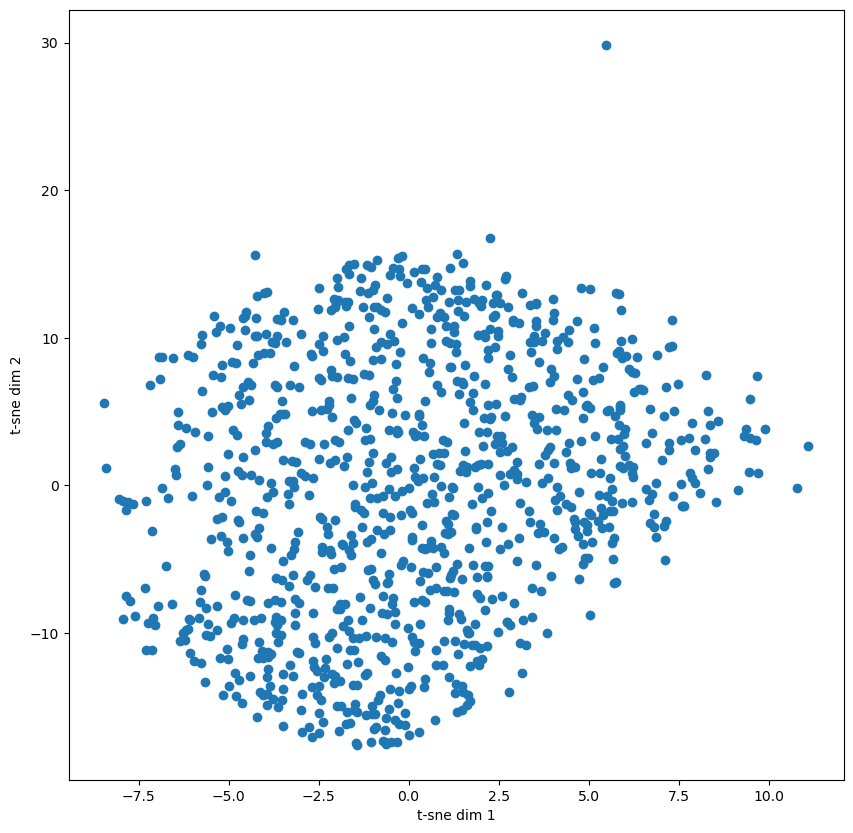

In [10]:
# Make a t-sne visualization of the representations of each video

from sklearn.manifold import TSNE

def t_sne_visualization(data: dict, average_over: str='repetitions') -> None:
    """
    Plot t-sne visualization of the data
    """

    if average_over == 'videos':
        dim = 0; ylabel='repetitions'; xlabel='voxels'
    elif average_over == 'repetitions':
        dim = 1; ylabel='videos'; xlabel='voxels'
    elif average_over == 'voxels':
        dim = 2; ylabel='videos'; xlabel='repetitions'
    else:
        raise ValueError('average_over must be one of "videos", "repetitions" or "voxels"')

    avg_per_voxel = np.mean(data['train_data'], axis=dim)
    print(avg_per_voxel.shape)
    tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
    tsne_results = tsne.fit_transform(avg_per_voxel)

    plt.figure(figsize=(10, 10))
    plt.scatter(tsne_results[:, 0], tsne_results[:, 1])
    plt.xlabel('t-sne dim 1')
    plt.ylabel('t-sne dim 2')
    plt.show()

t_sne_visualization(data, average_over='repetitions')

In [9]:
# Use nomic to generate atlas

from nomic import atlas
import numpy as np

embeddings = np.mean(data['train_data'], axis=1)
        
project = atlas.map_embeddings(embeddings=embeddings)

2023-07-01 01:50:57.923 | WARNING  | nomic.atlas:map_embeddings:91 - An ID field was not specified in your data so one was generated for you in insertion order.
2023-07-01 01:50:59.936 | INFO     | nomic.project:_create_project:749 - Creating project `nappy-snug` in organization `camilofosco`
2023-07-01 01:51:01.553 | INFO     | nomic.atlas:map_embeddings:107 - Uploading embeddings to Atlas.
1it [00:04,  4.46s/it]
2023-07-01 01:51:06.036 | INFO     | nomic.project:_add_data:1371 - Upload succeeded.
2023-07-01 01:51:06.036 | INFO     | nomic.atlas:map_embeddings:126 - Embedding upload succeeded.
2023-07-01 01:51:07.045 | INFO     | nomic.project:create_index:1081 - Created map `nappy-snug` in project `nappy-snug`: https://atlas.nomic.ai/map/5f8f20b9-b582-4259-a74f-3d23167c651a/5eb11d91-1786-4cc3-8120-edce9bb3499a
2023-07-01 01:51:07.046 | INFO     | nomic.atlas:map_embeddings:139 - nappy-snug: https://atlas.nomic.ai/map/5f8f20b9-b582-4259-a74f-3d23167c651a/5eb11d91-1786-4cc3-8120-edce9b

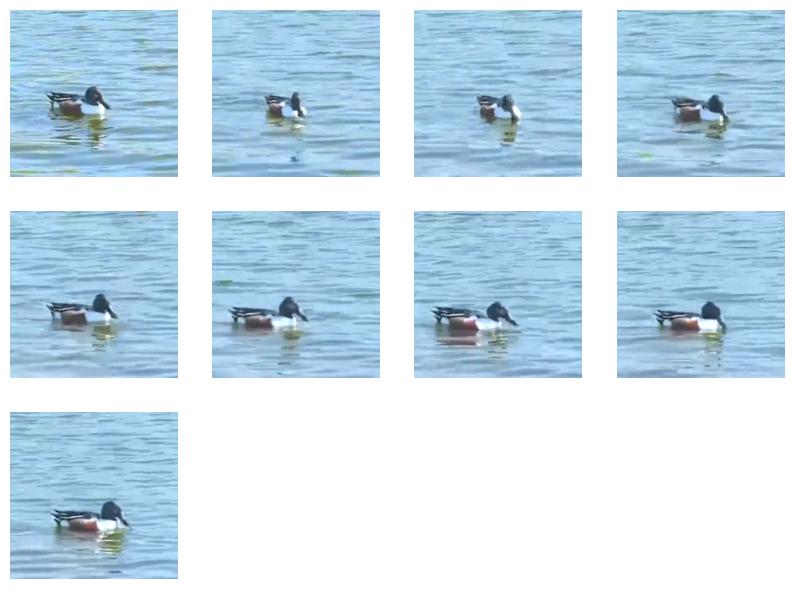

In [5]:
# Load a video and plot it

import cv2

def load_video(path):
    """
    Load a video and return it as a numpy array
    """
    cap = cv2.VideoCapture(path)
    frames = []
    while(cap.isOpened()):
        ret, frame = cap.read()
        if ret == False:
            break
        frames.append(frame)
    cap.release()
    return np.array(frames)

def plot_video(video, frames_to_skip):
    """
    Plot a video with a subplot for each frame, skipping frames_to_skip frames
    """
    plt.figure(figsize=(10, 10))
    for i, frame in enumerate(video[::frames_to_skip]):
        plt.subplot(4, 4, i + 1)
        plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
        plt.axis('off')
    plt.show()

video = load_video('./data/stimuli_mp4/0001.mp4')
plot_video(video, frames_to_skip=10)

Predicted memorability: 0.7708958387374878


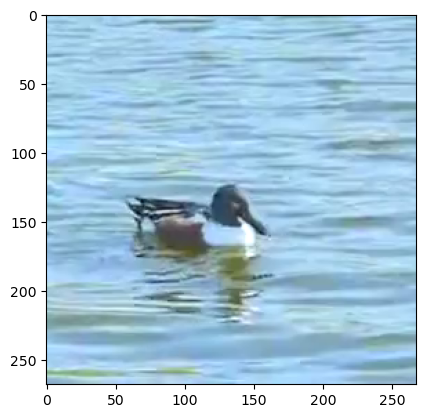

In [13]:
# Measure memorability of each frame using Vitmem

from vitmem import ViTMem
from PIL import Image
model = ViTMem()

# Transform video frame into PIL Image object
video_frame = Image.fromarray(cv2.cvtColor(video[0], cv2.COLOR_BGR2RGB))
# show image
memorability = model(video_frame)
print(f"Predicted memorability: {memorability}")

Loading caption model blip-large...
Loading CLIP model ViT-L-14/openai...
Loaded CLIP model and data in 14.14 seconds.


Flavor chain:   9%|▉         | 3/32 [01:26<13:58, 28.91s/it]


╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:14                                                                                   │
│                                                                                                  │
│   11 │   first_frame = Image.open(os.path.join(video_frames_folder, f, "001.png")).convert('R    │
│   12 │   # show image                                                                            │
│   13 │   plt.imshow(first_frame)                                                                 │
│ ❱ 14 │   print(ci.interrogate(first_frame))                                                      │
│   15 │   plt.show()                                                                              │
│   16                                                                                             │
│                                                                                                  │
│ /home/camilo/.local/lib/python3.8/site-packages/clip_interrogator/clip_interrogator.py:250 in    │
│ interrogate                                                                                      │
│                                                                                                  │
│   247 │   │   merged = _merge_tables([self.artists, self.flavors, self.mediums, self.movements   │
│   248 │   │   flaves = merged.rank(image_features, self.config.flavor_intermediate_count)        │
│   249 │   │   best_prompt, best_sim = caption, self.similarity(image_features, caption)          │
│ ❱ 250 │   │   best_prompt = self.chain(image_features, flaves, best_prompt, best_sim, min_coun   │
│   251 │   │                                                                                      │
│   252 │   │   fast_prompt = self.interrogate_fast(image, max_flavors, caption=caption)           │
│   253 │   │   classic_prompt = self.interrogate_classic(image, max_flavors, caption=caption)     │
│                                                                                                  │
│ /home/camilo/.local/lib/python3.8/site-packages/clip_interrogator/clip_interrogator.py:178 in    │
│ chain                                                                                            │
│                                                                                                  │
│   175 │   │   │   return False                                                                   │
│   176 │   │                                                                                      │
│   177 │   │   for idx in tqdm(range(max_count), desc=desc, disable=self.config.quiet):           │
│ ❱ 178 │   │   │   best = self.rank_top(image_features, [f"{curr_prompt}, {f}" for f in phrases   │
│   179 │   │   │   flave = best[len(curr_prompt)+2:]                                              │
│   180 │   │   │   if not check(flave, idx):                                                      │
│   181 │   │   │   │   break                                                                      │
│                                                                                                  │
│ /home/camilo/.local/lib/python3.8/site-packages/clip_interrogator/clip_interrogator.py:261 in    │
│ rank_top                                                                                         │
│                                                                                                  │
│   258 │   │   self._prepare_clip()                                                               │
│   259 │   │   text_tokens = self.tokenize([text for text in text_array]).to(self.device)         │
│   260 │   │   with torch.no_grad(), torch.cuda.amp.autocast():                                   │
│ ❱ 261 │   │   │   text_features = self.clip_model.encode_text(text_tokens)                       │
│   262 │   │   │   text_features /= text_features.norm(dim=-

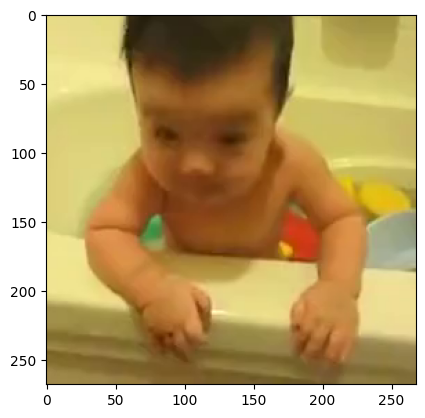

In [4]:

# Perform clip interrogation over all first frames of the videos of interest

from PIL import Image
from clip_interrogator import Config, Interrogator

video_frames_folder = './data/10_videos_for_reconstruction_test/frames'

ci = Interrogator(Config(clip_model_name="ViT-L-14/openai"))



In [ ]:
for f in os.listdir(video_frames_folder):
    first_frame = Image.open(os.path.join(video_frames_folder, f, "001.png")).convert('RGB')
    # show image
    plt.imshow(first_frame)
    print(ci.interrogate(first_frame))
    plt.show()